### **ASSIGNMENT #2 - DATA SCIENCE AND DECISION MAKING.**
**STAGE 1: DATA EXPLORATION - REVISED AND FIXED VERSION**

*NOTEBOOK MADE BY: JUAN DAVID VELASQUEZ RESTREPO - 2400901*

VERSION 2 - CORRECTIONS ADDED:
- Recurrent Feature Elimination was added (RFE).
- The Diagonal of the Correlation Matrix was fixed.
- Plot of how are the classes distributed after converting them into 4 different labels. Also, the percentage of each class was added.
- The Datasets are now saved as .CSV.

This first section imports all the necessary libraries for the proper code functioning, such as the library that allows the developer to plot some information from the data with certain types of plots (countplots, histograms and heatmaps) arrays management, robust scaler for data processing, PCA, skew transformer (Quantile transformer), mutual info classif (mainly used to determine how correlated are the categorical variables among them and with the labels), ordinal encoder for categorical data, the KNN imputer which by using a ML model the NaNs can be replaced using the data from the other columns and rows, and the train test splitter.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import norm
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import QuantileTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import KNNImputer
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

This section is composed by the definition of functions that will be used throughout the code which were called more than once and will be highly important for the data analysis of the dataset given.

In [2]:
# This function extracts basic information of the input dataset, such as dataset size (rows and columns), number of NaNs or invalid values, types of data,
# columns with unique values and the number of duplicated rows. Also, this function determines if there is any repeated participant id, since according to
# the data information and project description, each patient must be different.

def infos(data):
  # The following 2 lines print and access to the first and second position of the array of shape, each associated to the rows and columns. Subsequently, this
  # is printed.
  print(f"The Dataset of matrices has {data.shape[0]} rows and {data.shape[1]} columns.\n\nSome other info of the data:")
  print(data.info())

  # The following lines, sum up all the NaNs in the dataset from every column, that's why .sum is written twice, because the first sums the nans for each column but the
  # second one, sums all the NaNs of each column, which a single number can be gotten. Then it is asked if there are NaNs in the dataset and a message will be displayed.
  # If not, then another message will pop up indicating that the dataset does not contain NaNs.

  if data.isna().sum().sum() > 0:
    print(f"\nThere are {data.isna().sum().sum()} NaNs in the dataset.\n")
  else:
    print("\nThere are no NaNs in the dataset.\n")

  # The following lines calculate the number of unique data types found in the dataset. Using "len()" determines the size of the array returned by the method
  # "data.dtypes.unique()" which holds all the datatypes of the input dataset.
  # In addition, this section prints in form of list the datatypes found (without repetitiion).

  print(f"There are {len(data.dtypes.unique())} types of data, these include:")
  for dtype in data.dtypes.unique():
    print("- ", dtype)

  # This variable saves the columns that hold one unique value. This is achieved by using the method "nunique" which counts the number of unique values, but
  # in the same time a condition is written asking if this count is equal to 1. If this occurs, the column's name is saved in the variable.

  uniq_cols = data.columns[data.nunique() == 1]

  # The next line contains an if with prints, where a message will be showed depending on the size of the array described previously. In this case if the size
  # is above 1, a message indicating that columns with unique values were found, if not, the opposite message is displayed.

  print(f"\nThe columns {uniq_cols} have an unique value.") if len(uniq_cols) > 0 else print(f"\nThe dataset does not have columns with unique values.")

  # Using the method ".duplicated()" from pandas, allows the code to find duplicated rows across the data, but, using the method ".sum()" sums up the number of
  # duplicated rows. Once the sum is performed, this information is saved in the variable "uniq_rows".

  uniq_rows = data.duplicated().sum()

  # The print below will display a message showcasing if duplicated rows were found or not.

  print(f"\nThe dataset has {uniq_rows} duplicated rows") if uniq_rows > 0 else print(f"\nThe dataset does not have duplicated rows")


  # Considering the information given by the data dictionary as well as the project description, the participants are all different and should not be repeated.
  # In this case, the next lines determine if the number of unique id's of the participants are equal to the number of rows of the input data. If the number
  # matches in both cases, a message indicating that the id's are unique will be showed. If not, then will pop up message that not all participants are unique.

  if data['participant_id'].nunique() == data.shape[0]:
    print("All values in 'participant_id' are unique")
  else:
    print("Not all values in 'participant_id' are unique")

# The following function allows the code to sum the NaNs of each column, then by using the number of rows of the dataset, the percentage of NaNs of
# each column is calculated and sorted in an ascending way. Subsequently, the number of NaNs is obtained and the index of this data corresponds
# to the column name. In this case, when the percentage of NaNs and its number are concatenated, forming a dataframe, this information is printed but
# only for those rows whose percentage value is above 0%, showcasing the columns with NaNs. In addition, the dataframe formed is returned.

def perc_nans(data):
  percentage = np.round((data.isnull().sum()/data.shape[0]).sort_values(ascending=False), decimals = 2)
  missing_data = pd.concat([data.isnull().sum().sort_values(ascending=False), percentage], axis=1, keys=['Total', 'Percentage'])
  print("These are the columns with the percentage of missing values:\n\n", missing_data[missing_data['Percentage'] > 0])
  return missing_data

# "mi_cl" is the function that allows the code to obtain the mutual information between two columns. In this case, the inputs col1 and col2 will be the
# columns with categorical values (either ordinal or nominal values). Once the two columns are called in the function, the two lines with the method
# ".reshape(-1, 1)" were written in order to avoid any problems with the dimension compatibility of the function "mutual_info_classif" since it requires
# that its inputs must be in the form of a column matrix. Aditionally, a random state of 42 was assigned in order to ensure repeatability in the results.
# n_jobs of -1 allows that all processors will be used for the calculation and discrete_features is assigned as True because the aim of this function is
# to input categorical data only. Finally, the [0] at the end will return a scalar value instead of the resulting array.

def mi_cl(col1, col2):
    col1 = col1.reshape(-1, 1)
    col2 = col2.reshape(-1, 1)
    return mutual_info_classif(col1, col2, discrete_features=True, random_state = 42, n_jobs = -1)[0]

# This function receives the names of the columns to plot, the dataframe, a boolean variable indicating if more than one plot will be required, the palette
# of colours and the title of the plots.

def countplots(columns_to_plot, data, multi, palette = 'viridis', title = 'plot'):

  # Once the function is called along with the inputs, if multi is true, then:
  # First, the number of rows of plots is calculated. In this case, if the number of columns to plot is even, then the number will be rounded (for instance if
  # columns to plot plus 1 is equal to 9 and then divided by 2, the result is 4.5, but using the double "//" this is rounded to 4), the same situation is for the
  # the odd numbers.
  # Once is calculated, the number of rows is obtained and the subplots method is called. Its inputs will be the number of rows to plot, the 2 columns of each row and
  # the corresponding figure size of each plot. Afterwards, the axis array is flattened for ease since each position corresponds to the plot to show on each row and column.
  # A for cycle is written in order to iterate over the array of columns to plot, and in the same time, considers the index of the column to plot, which is necessary to
  # access to the plot itself and modify such as the colour palette, title and grid.
  # Once each column is plotted, a new for cycle is written in order to delete the remaining axes that won't be used in the subplot (this happens in the case of odd number
  # of columns to plot).

    if multi:
        rows = (len(columns_to_plot) + 1) // 2
        fig, axes = plt.subplots(rows, 2, figsize=(12, 8))

        axes = axes.flatten()

        for i, col in enumerate(columns_to_plot):
            sns.countplot(x=data[col], ax=axes[i], palette = palette)
            axes[i].set_title(f'{col} {title}')
            axes[i].grid(True)

        for j in range(i + 1, len(axes)):
            fig.delaxes(axes[j])

        plt.tight_layout() # Adjusts the subplots distribution making them more legible and avoiding superpositions.
        plt.show() # Plots are displayed.

# Now, if multi is False:
  # First, the size of the plot is assigned. Then, the countplot function is called by putting as inputs the columns of the dataframe and in
  # the same time, it's melted in the format of a column and the values. In this case, each row will contain the column name and the values it can take. This format is easier
  # for the countplot to work. In addition, the inputs of ".countplot" which are "x" and "hue" each correspond to the name of the axis x and hue is to differentiate each bar
  # on the plot.

    else:
        plt.figure(figsize=(12, 8))
        sns.countplot(data=data[columns_to_plot].melt(), x='value', hue='variable')
        plt.title(title)
        plt.xlabel("Values")
        plt.ylabel("Count")
        plt.grid(True)
        plt.legend(title="Columns")
        plt.show()

# The following function builds a triangle shaped correlation map. Its inputs are the correlation matrix, the palette of colours and the plot title.
# In order to create a triangle shaped plot (given that the data is mirrored above and below the diagonal) for a better reading and more attractive
# representation of the data correlation, it is important to define a mask which determines how do the code will show the data. In this case, first a
# boolean matrix is generated thanks to the method "mp.ones_like" with the size of the correlation matrix. Once done, "np.triu" will cut the matrix out
# holding only the data below its diagonal. This now, will represent how the correlation map will be showed.
# After this, the size of the plot is assigned, the heatmap is generated with its corresponding palette, mask and correlations values and its title.

def corr_map(data_correlated, palette = None, title = 'Correlation Matrix'):

  # A new condition was added. This will ensure that the whole information of the correlation of the labels is displayed rather than only showing
  # the first diagonal.

  if data_correlated.shape[0] > 2:
    mask = np.triu(np.ones_like(data_correlated, dtype=bool))
    plt.figure(figsize=(25, 7))
    sns.heatmap(data_correlated, annot=True, cmap=palette, mask=mask)
    plt.title(title)
    plt.show()
  else:
    plt.figure(figsize=(25, 7))
    sns.heatmap(data_correlated, annot=True, cmap=palette)
    plt.title(title)
    plt.show()    

# label_countplot is the function that allows the code to determine how each column of the data is correlated with the output labels and at the same time plots the
# correlation value in a descending way. Once done, extracts a dataframe of these results and removes the columns whose correlation with the two labels is below 0.005,
# considering this a very low correlation value and besides, indicates that the column itself does not contributes enough to determine the behaviour of the labels.
# Finally, this function also evaluates what columns have a correlation above 0.8 and after this, removes them all printing which were deleted.

# This function receives as input, the data merged with the labels and the data without labels, as well as the method of correlation to implement (can be either
# pearson or mi_cl).

# Thirdly, once the correlation dataframe is built for each label, both of them are concatenated using the same indices of each dataframe, where the index correspond to
# the column name, therefore, in order to do this, left and right index in the merge method must be true.

# Finally, the function returns in the form of an array, the columns that were deleted throughout the function.


def label_countplot(data_labels, data, method = 'pearson'):

  # First, the variable that will hold the columns deleted is declared as well as the figure axis. As seen below there's only one row and two plots, as
  # input parameters along with its corresponding size.
  # Secondly, the correlation matrix of the data is calculated for the first column of the labels. Then the column labels are dropped since it's not important to display
  # the correlation with themselves. In addition, the plot is made in the form of bars and with the grid on.

  del_cols = []

  fig, axes = plt.subplots(1, 2, figsize=(14, 5))
  correlations_adhd = data_labels.corr(method = method)["ADHD_Outcome"].drop(["ADHD_Outcome", "Sex_F"])
  correlations_adhd.sort_values(ascending=False).plot(kind="bar", ax=axes[0], grid=True)
  axes[0].set_title("Correlation with ADHD Outcome")
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90) # Gets the X-axis labels (column names).

  correlations_sex = data_labels.corr(method = method)["Sex_F"].drop(["ADHD_Outcome", "Sex_F"])
  correlations_sex.sort_values(ascending=False).plot(kind="bar", ax=axes[1], grid=True)
  axes[1].set_title("Correlation with Sex_F")
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90) # Gets the X-axis labels (column names).

  plt.tight_layout()
  plt.show()

  corrs = pd.merge(correlations_adhd, correlations_sex, left_index=True, right_index=True)
  display(corrs)

  # Fourthly, a for loop is made in order to iterate over the rows of the merged dataframe and there, if the values of both columns are below 0.005 (which corresponds to
  # a very low correlation with the label) the column will be deleted. Since the index of the row holds the name of the column, the "data.drop()" method input will be
  # the index of the merged dataframe and its axis will be 1 given that the elimination will be column wise and inplace is true because the original data will be modified.
  # In addition, the name of the column deleted will be printed.

  for i in range(corrs.shape[0]):
    if(abs(corrs.iloc[i,0]) < 0.005 and abs(corrs.iloc[i,1]) < 0.005):
      data.drop(corrs.index[i], axis = 1, inplace = True)
      del_cols.append(corrs.index[i])
      print(f"The column {corrs.index[i]} was deleted from the data (Low importance and Low Correlation with labels).")


  # Lastly, here is calculated the correlation matrix of the data. Then, the absolute value is obtained given that some results might be negative and again, the same mask
  # is generated as explained before, but with the particular attribute "k", which if its value is 1, the diagonal with values equal to 1 will not be included.
  # In addition, the method ".where()" removes all the data that is in and below the diagonal of the correlation matrix. This will return a filtered dataframe.
  # The last 4 lines of code make the iteration over the columns of the upper dataframe, where by determining if the correlation is equal or above 0.8 the column will be
  # deleted and the name of column will be printed as well.


  # Part of this code was implemented using the source: https://www.projectpro.io/recipes/drop-out-highly-correlated-features-in-python

  corr_matrix = data.corr(method = method).abs()
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

  for column in upper.columns:
    if any(upper[column] >= 0.8):
      print(f"The column {column} was deleted from the data (High correlation with another column).")
      data.drop(column, axis = 1, inplace = True)
      del_cols.append(column)

  return del_cols

# The following code iterates over all the rows in the label dataset and asks the values of each column. This encoding will be performed as follows:
  # Class 0: If not ADHD and Male.
  # Class 1: If not ADHD and Female.
  # Class 2: ADHD and Male.
  # Class 3: ADHD and Female.

  # Once the encoding is completed, the modified dataframe is returned with a single column called 'y'.
  # This encoding is done to allow the development of a single classifier instead of two for the
  # classification of the participant's sex and ADHD diagnosis, which might facilitate the creation of
  # a unified model for the entire project.

def label_encoder(labels):
  for i in range(labels.shape[0]):
    if(labels.iloc[i,0] == 0 and labels.iloc[i,1] == 0):
      labels.iloc[i,0] = 0 # Not ADHD, Male
    elif(labels.iloc[i,0] == 0 and labels.iloc[i,1] == 1):
      labels.iloc[i,0] = 1 # Not ADHD, Female
    elif(labels.iloc[i,0] == 1 and labels.iloc[i,1] == 0):
      labels.iloc[i,0] = 2 # ADHD, Male
    else:
      labels.iloc[i,0] = 3 # ADHD and Female

  labels.drop(columns=['Sex_F'], inplace=True) # The column of sex is deleted, ensuring that only will be held.
  labels.rename(columns={'ADHD_Outcome': 'y'}, inplace=True) # The only column is renamed to 'y'.

  return labels

# The following function will import a recurrent feature elimination model from the sklearn package. For this case, a logistic regression model is implemented for this process.
# Using an iteration of 5000 and selecting the number of features equal to the number of features in the input data, the idea is to determine the percentage of impotance of each 
# feature and with this, remove all those that are fairly low in importance or not relevant for the prediction.
def rfe(data, y_train):

  selector = RFE(estimator = LogisticRegression(max_iter = 5000), n_features_to_select = data.shape[1]) # RFE model imported as Logistic Regressor.
  selector = selector.fit(data, y_train) # The selector is fitted to the data.

  selected_features = data.columns[selector.support_] # All the columns are selected.
  df_coefficients = pd.DataFrame(np.abs(selector.estimator_.coef_[0] ) / np.sum(np.abs(selector.estimator_.coef_[0] )) * 100, index = selected_features, columns=['Coefficient'])
  # The previous line calculates the percentage of importance of each column.
  # display(df_coefficients.sort_values(by='Coefficient', ascending=False)) # Results are displayed.

  cols = np.array([])

  for i in range(df_coefficients.shape[0]): # A for loop is generated to iterate over the percentage of importance of each column and remove all whose value is below 1%.
    if(df_coefficients.iloc[i,0] < 1.0):
      print(f"The column {df_coefficients.index[i]} was deleted from the data (Low importance).")
      data = data.drop(df_coefficients.index[i], axis = 1, inplace = False)
      cols = np.append(cols, df_coefficients.index[i])
      
  return pd.DataFrame(data), cols

This code cell imports the data provided, such as Functional Connectome Matrices, Metadata_A, Metadata_B and Labels. All of them were imported using the pandas method "pd.read_excel" since they are .xlsx files except but Functional Connectome matrices, which is a .csv whose data are separated by commas.

In [3]:
data_max = pd.read_csv('FUNCTIONAL_CONNECTOME_MATRICES.csv', sep=',')
data = pd.read_excel('METADATA_A.xlsx')
labels = pd.read_excel('LABELS.xlsx')
dataB = pd.read_excel('METADATA_B.xlsx')

# **Metadata_A General Analysis**

Here, the function infos is called in order to get basic information of the Metadata_A.

In [4]:
infos(data)

The Dataset of matrices has 1213 rows and 19 columns.

Some other info of the data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1213 entries, 0 to 1212
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   participant_id              1213 non-null   object 
 1   EHQ_EHQ_Total               1213 non-null   float64
 2   ColorVision_CV_Score        1213 non-null   int64  
 3   APQ_P_APQ_P_CP              1213 non-null   int64  
 4   APQ_P_APQ_P_ID              1213 non-null   int64  
 5   APQ_P_APQ_P_INV             1213 non-null   int64  
 6   APQ_P_APQ_P_OPD             1213 non-null   int64  
 7   APQ_P_APQ_P_PM              1213 non-null   int64  
 8   APQ_P_APQ_P_PP              1213 non-null   int64  
 9   SDQ_SDQ_Conduct_Problems    1213 non-null   int64  
 10  SDQ_SDQ_Difficulties_Total  1213 non-null   int64  
 11  SDQ_SDQ_Emotional_Problems  1213 non-null   int64  
 12  SDQ_SD

Given the information above, most of the data is in form of integers, except but MRI_Track_Age_at_Scan, EHQ Total and participant_id. Where, comparing the results with the data dictionary, all of them matches correspondingly. In this case, it's important to consider that since the dictionary states that "participant_id" must be a string type, pandas considers that any non numeric data must be a object type.

On the other hand, regarding the NaNs detected, there are 360 NaNs located in this dataset, which considering that the data has 1213 rows, almost a 1/4 part of the rows must be either modified or deleted. In the next section, this will be discussed in further.

According to the remaining information provided by the function, the dataset does not have participants repeated, all of them are unique as well as the rows.

Now that the basic information of the dataset was analyzed, the next step is to modify the analyze the dataset B.

# **Metadata_B General Analysis**

In [5]:
infos(dataB)

The Dataset of matrices has 1213 rows and 10 columns.

Some other info of the data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1213 entries, 0 to 1212
Data columns (total 10 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   participant_id                    1213 non-null   object 
 1   Basic_Demos_Enroll_Year           1213 non-null   int64  
 2   Basic_Demos_Study_Site            1213 non-null   int64  
 3   PreInt_Demos_Fam_Child_Ethnicity  1202 non-null   float64
 4   PreInt_Demos_Fam_Child_Race       1213 non-null   int64  
 5   MRI_Track_Scan_Location           1213 non-null   int64  
 6   Barratt_Barratt_P1_Edu            1213 non-null   int64  
 7   Barratt_Barratt_P1_Occ            1213 non-null   int64  
 8   Barratt_Barratt_P2_Edu            1213 non-null   int64  
 9   Barratt_Barratt_P2_Occ            1213 non-null   int64  
dtypes: float64(1), int64(8), object(1)
memory usage:

Analyzing the information provided above, the infos function has showned that the dataset B has mostly data in the form of integers, except but participant_id and PreInt_Demos_Fam_Child_Ethnicity. In this case, comparing the datatypes with the dictionary provided, the latter does not match at all, because it is expected to be int instead of float, therefore, in further sections, this column will be analyzed and checked if might be related to a data reading with one decimal or whether the data was typed incorrectly.
On the other hand, this dataset have 11 NaNs, hence is not a high amount of NaNs at all and if they are changed by the mode (the most common value) the impact is not significant given that there are more than 800 rows in the data. In addition, it's important to highlight that the participant ids are all unique and the dataset has no duplicated rows, indicating that there are no repeated samples to remove.

# **Functional_Connectome_Matrices**

In [6]:
infos(data_max)

The Dataset of matrices has 1213 rows and 19901 columns.

Some other info of the data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1213 entries, 0 to 1212
Columns: 19901 entries, participant_id to 198throw_199thcolumn
dtypes: float64(19900), object(1)
memory usage: 184.2+ MB
None

There are no NaNs in the dataset.

There are 2 types of data, these include:
-  object
-  float64

The dataset does not have columns with unique values.

The dataset does not have duplicated rows
All values in 'participant_id' are unique


This part of the dataset which includes the highest volume of columns does not have any NaNs as seen above, also include two datatypes as expected, one given by the participant id and the numbers from the measurements obtained. In this case, this dataset does not require a NaNs processing so far.

# **Labels General Analysis**

In [7]:
infos(labels)

The Dataset of matrices has 1213 rows and 3 columns.

Some other info of the data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1213 entries, 0 to 1212
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   participant_id  1213 non-null   object
 1   ADHD_Outcome    1213 non-null   int64 
 2   Sex_F           1213 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 28.6+ KB
None

There are no NaNs in the dataset.

There are 2 types of data, these include:
-  object
-  int64

The dataset does not have columns with unique values.

The dataset does not have duplicated rows
All values in 'participant_id' are unique


Checking the output of the function infos, it is important to highlight that this dataset includes int types mostly and there are no NaNs to process. Also the participants are all unique.

## **Data Split into Training and Test Set**

Given that all the participants id are unique and there are no repeated rows in each dataset, it's now possible to merge all the data and split all them up in order to proceed with the data processing and deep analysis. The next section merges all the data by matching up the participants id.
On the other hand, the data is splitted with a train size of 80% and shuffled in order to assure that the data is as more general as possible without having any sort of order in it.

In [8]:
dataset = pd.merge(data, data_max, on='participant_id').merge(dataB, on='participant_id').merge(labels, on='participant_id').drop(columns=['participant_id'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(dataset, labels, random_state=42, train_size = 0.8, shuffle = True)

This section extracts only the training and testing rows from the original dataset, preserving its integrity. This approach ensures that the original training and test sets remain unchanged while improving variable comprehension and processing, rather than directly modifying *X_train* and *X_test*. At the end of the notebook, they will be all merged forming again the sets previously obtained in the splitting.

In [9]:
# Each line ensures that the copies only hold numerical values, that's why the method "select_dtypes(include=np.number)" is added.
data = X_train[(data.select_dtypes(include=np.number)).columns]
dataB = X_train[(dataB.select_dtypes(include=np.number)).columns]
data_max = X_train[(data_max.select_dtypes(include=np.number)).columns]
labels = y_train[(labels.select_dtypes(include=np.number)).columns]
labels_test = y_test[(labels.select_dtypes(include=np.number)).columns]
data_max_test = X_test[(data_max.select_dtypes(include=np.number)).columns]

In [10]:
y_train.drop('participant_id', axis=1, inplace=True)

## **Labels: Analysis in depth**

First, let's see how the labels are built and what data can be seen in the first 5 rows.

In [11]:
labels.head()

,ADHD_Outcome,Sex_F
971,0,0
352,1,1
676,1,0
671,1,1
982,0,0


The next step, is to generate a countplot which can showcase how distributed is each class in the labels, and determine if they are either balanced or imabalanced. Subsequently, determine what models can suit better for each case (also is important to provide a paramater of class weight when training the model in order to avoid giving more importance to the most repeated class) and besides, determine what evaluation methods could be implemented.

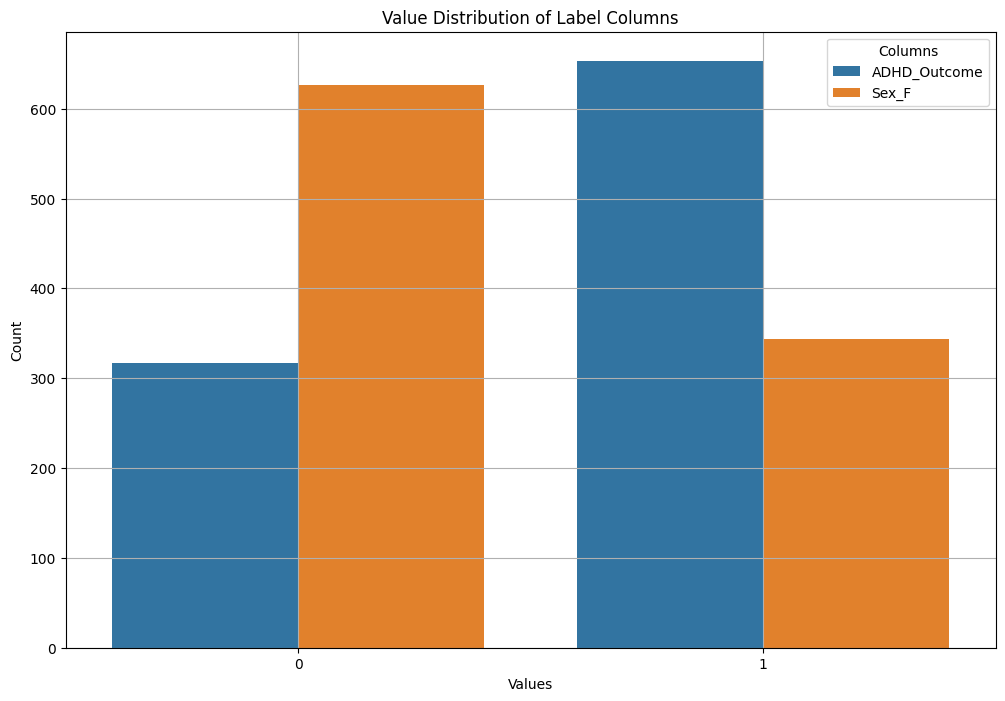

ADHD_Outcome
1    67.0
0    33.0
Name: count, dtype: float64
This label is imbalanced in: 35%


Sex_F
0    65.0
1    35.0
Name: count, dtype: float64
This label is imbalanced in: 29%




In [12]:
countplots(labels.columns, labels, False, 'paired', 'Value Distribution of Label Columns') # Countplot function called, no multiplots required.

for i in (labels.columns): # This line iterates over all columns and prints out the percentage of each class, as well as its difference.
  print(f"{round(labels[i].value_counts() / labels.shape[0] * 100)}\nThis label is imbalanced in: {round(abs(labels[i].value_counts()[0] / labels.shape[0] * 100 - labels[i].value_counts()[1]/ labels.shape[0] * 100))}%\n\n")


Given the last plot, it is certainly evident that the classes are highly imbalanced in each case. As seen, the class ADHD_Outcome has a difference of 35%, being class "1" the most common over the class "0", indicating that the experiments were carried out on more persons with ADHD than healthy patients.

On the other hand, regarding the class Sex_F, this one is also highly imbalanced with a difference of 29%, the class "0" surpasses the class "1" indicating that most of the participants were males. This reflects that most of the experiments were made to males with diagnosed ADHD rather than healthy females, which might lead that the models to be trained may perform better to predict males with ADHD.

The next plot showcases the correlation between each label and determine if sex has a visible correlation with ADHD or viceversa.

(2, 2)


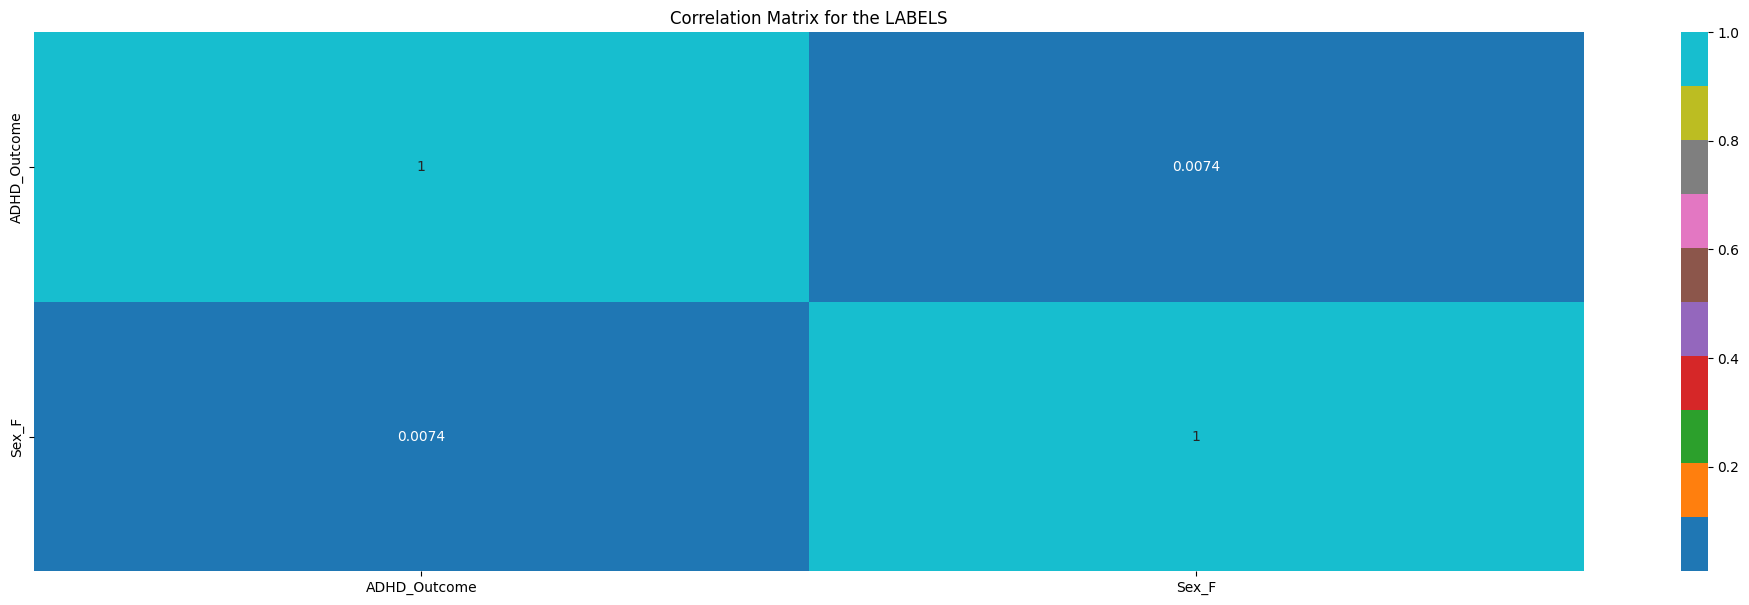

In [13]:
corrmat = labels.corr(method = mi_cl)
print(corrmat.shape)
corr_map(corrmat, title = 'Correlation Matrix for the LABELS', palette = 'tab10')

As seen in the previous plot, the correlation between the labels is very low, indicating that, in general, sex is not strongly related to the presence of ADHD. This suggests that one variable does not depend on the other in this context.

## **Metadata_A: Analysis in depth**

Here, the idea is to determine the percentage of NaNs or invalid data that each column of the data has. In this case, it's printed the total of NaNs as well as its percentage considering the whole data of the column.

In [14]:
missing_data = perc_nans(data)

These are the columns with the percentage of missing values:

                        Total  Percentage
MRI_Track_Age_at_Scan    284        0.29


As seen previously, 29% of the values of the column "MRI_Track_Age_at_Scan" have invalid data. In this case, since it's a moderate number of rows in the data, by removing them, this might further impact the models performance by reducing the dataset size in samples and determinant information for the classification process from other columns might get lost, which in conclusion, this is not an appropiate alternative. Hence, the option of applying a KNN imputer might fit in this situation.

First, it's necessary to call the imputer and choose the number of neighbours required, in this case, the number of 3 will be selected. Once done, the dataset that contains the training part of Metadata_A will be fitted and imputed, then, using this model, the imputter will transform the columns on the test dataset an the result will be saved.

In [15]:
imputer = KNNImputer(n_neighbors=3) # Imputer is called with its corresponding neighbours.
data = pd.DataFrame(imputer.fit_transform(data), columns=data.columns) # The imputer is fitted with the training data, as well as transforms it.
data_test = pd.DataFrame(imputer.transform(X_test[data.columns]), columns=data.columns) # Here the test set is also transformed.

Part of this code was implemented using the source: https://www.geeksforgeeks.org/detect-and-remove-the-outliers-using-python/

The following code obtains the quantile ranges (0.25 and 0.75) of the data and obtains the list of column with most outliers. Once gotten, the interquantile range is calculated, then the outliers are acquired by determining the sum of values that are below q1 - 1.5 * iqr and above q3 + 1.5 * iqr (using the general formula for detecting outliers in the data). After this, the sum will be made column wise and the result will return a dataframe whose indices will be the columns and the only column the number of outliers of each. The method "index.tolist()" allows the code to convert the indices into a list which will be used to build a descending list of the columns with the most outliers in the data.

The last two lines of code print the ranking of outliers.

In [16]:
q1 = data.select_dtypes(include=np.number).quantile(0.25) # First quantile.
q3 = data.select_dtypes(include=np.number).quantile(0.75) # Third quantile.
iqr = q3 - q1 # The difference is the interquantile range.
outliers = ((((data < (q1 - 1.5 * iqr)) | (data > (q3 + 1.5 * iqr))).sum())).sort_values(axis=0, ascending=False).index.tolist() # The data is searched, compared and sorted. With this
# the outliers are obtained.
print("The ranking of features with the most outliers are: ") # Here the sorted list of outliers is displayed.
for i in range(len(outliers)):
    print(f"{i+1}. {outliers[i]}")

The ranking of features with the most outliers are: 
1. ColorVision_CV_Score
2. APQ_P_APQ_P_CP
3. EHQ_EHQ_Total
4. APQ_P_APQ_P_PM
5. APQ_P_APQ_P_OPD
6. SDQ_SDQ_Conduct_Problems
7. MRI_Track_Age_at_Scan
8. APQ_P_APQ_P_INV
9. APQ_P_APQ_P_ID
10. APQ_P_APQ_P_PP
11. SDQ_SDQ_Internalizing
12. SDQ_SDQ_Emotional_Problems
13. SDQ_SDQ_Externalizing
14. SDQ_SDQ_Difficulties_Total
15. SDQ_SDQ_Hyperactivity
16. SDQ_SDQ_Generating_Impact
17. SDQ_SDQ_Peer_Problems
18. SDQ_SDQ_Prosocial


As seen, the columns with most outliers are "ColorVision_CV_Score", "APQ_P_APQ_P_CP" and "EHQ_EHQ_Total", indicating that these columns hold the most dispersion of data, let's now see how is this reflected with boxplots.

The next section plots the ranking of the outliers using the code of the function "countplots", but the only difference is that here is used boxplots instead of countplots.

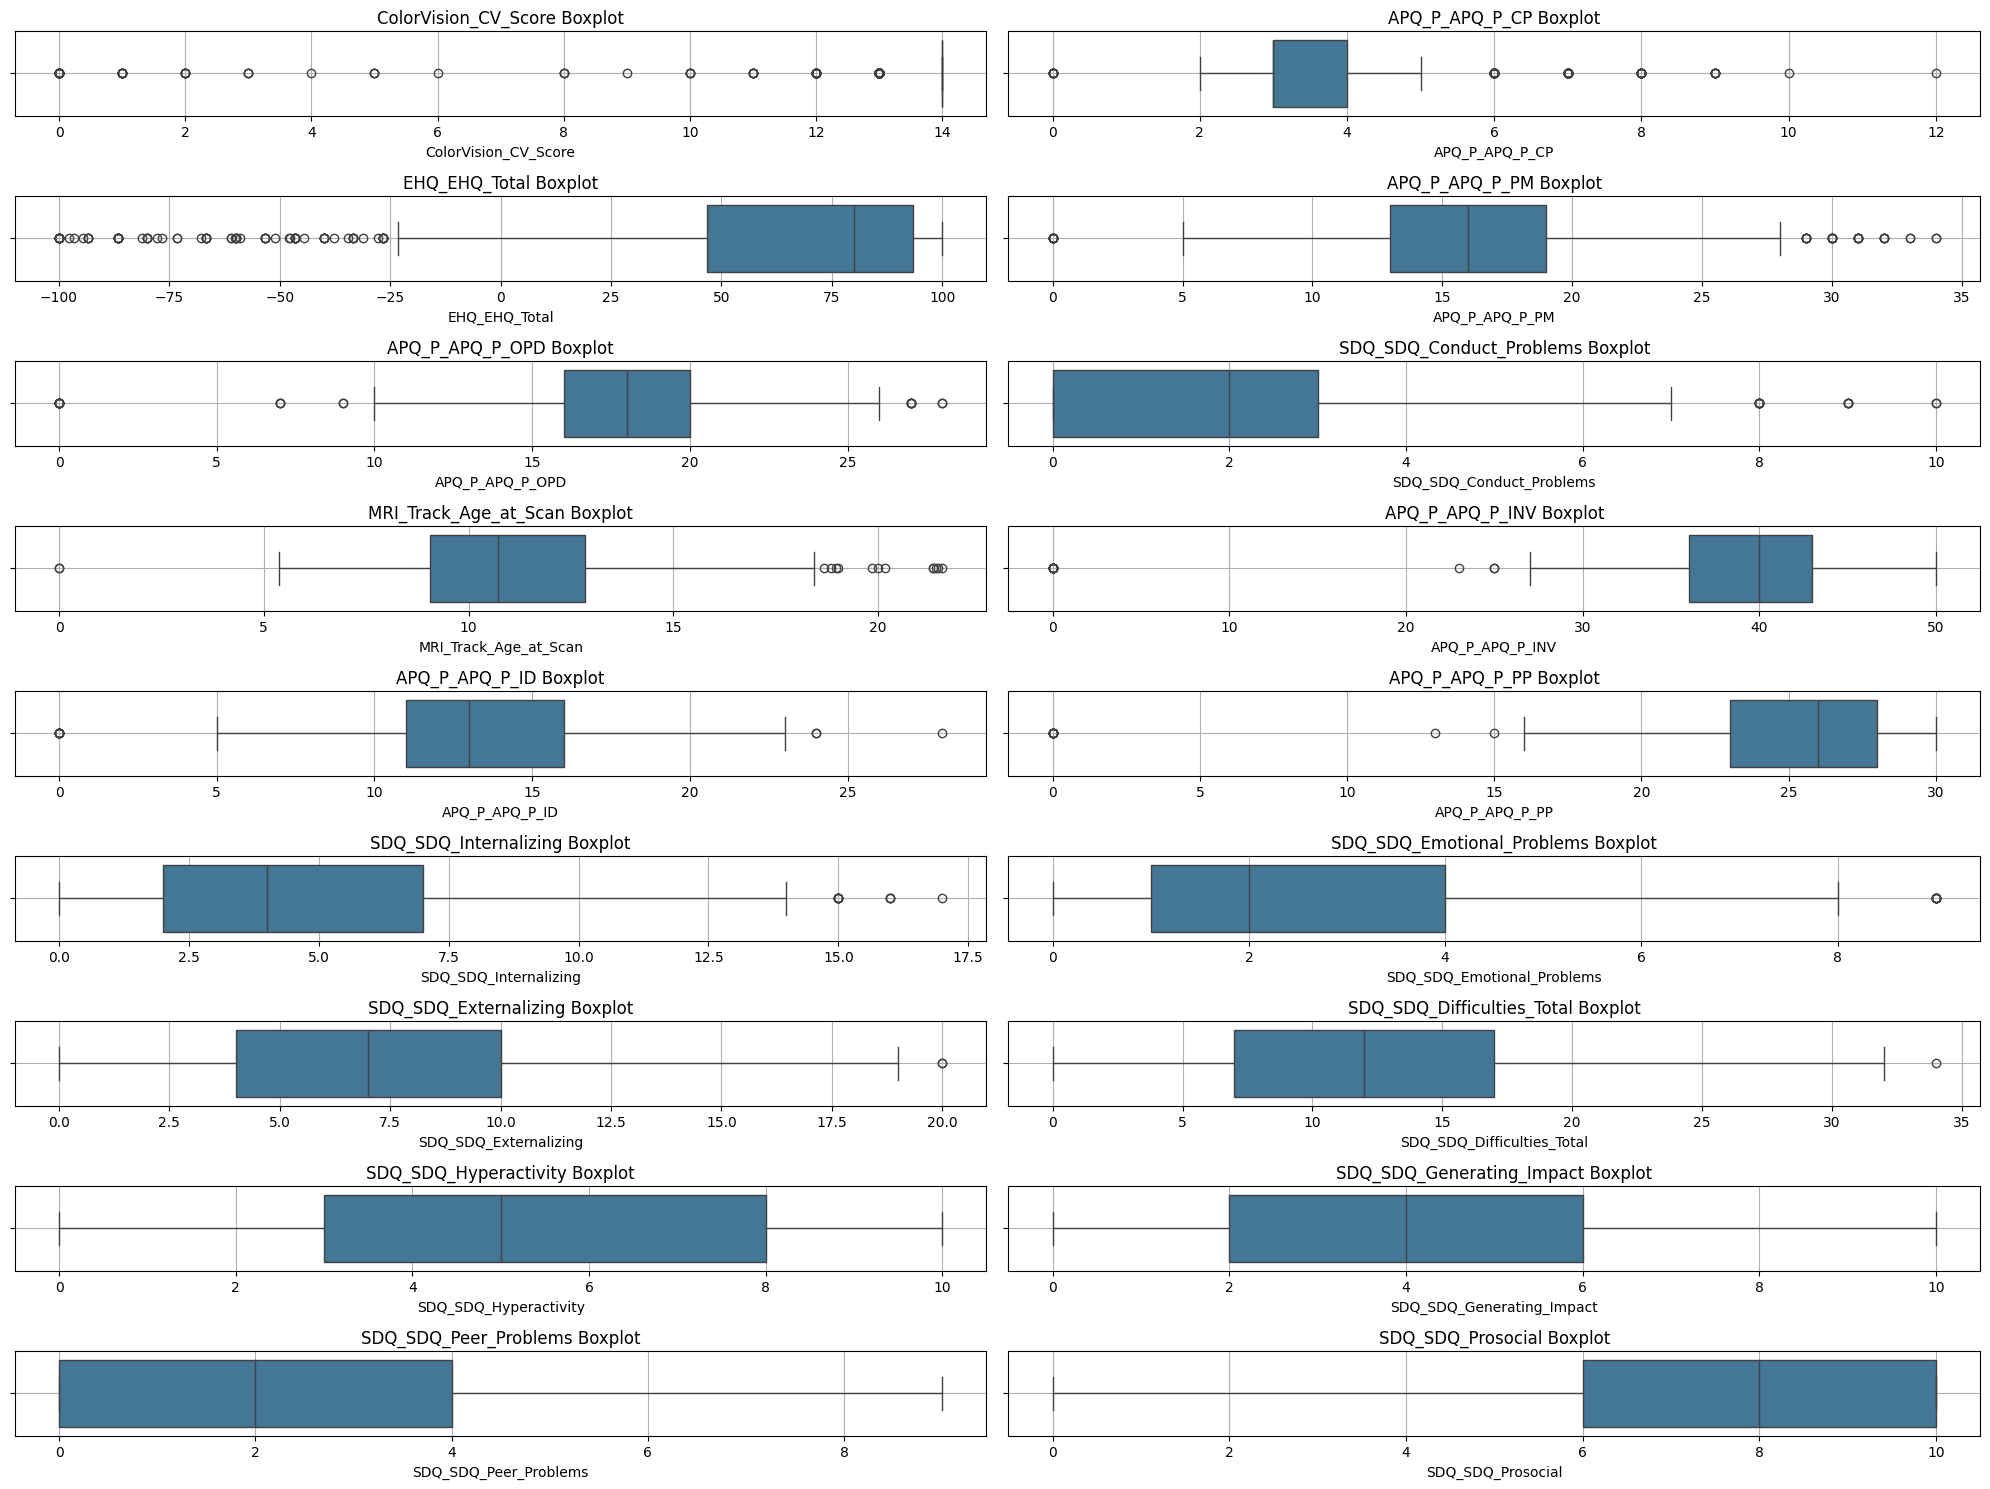

In [17]:
rows = (len(data.columns) + 1) // 2
fig, axes = plt.subplots(rows, 2, figsize=(20, 15))

axes = axes.flatten()

for i, col in enumerate(outliers):
      sns.boxplot(x=data[col], ax=axes[i], palette = 'mako')
      axes[i].set_title(f'{col} Boxplot')
      axes[i].grid(True)

for j in range(i + 1, len(axes)):
      fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

The most interesting plot obtained is "ColorVision_CV_Score" given that most of the data is contained in a thin vertical line and many outliers lie on extreme values far away from from the rest of data, making the data held in the IQR look small and not significative. On the other hand, regarding the boxplot of "EHQ_EHQ_Total" there is high amount of data points outside the interquantile range reaching up -100 when most of the data lies on 50 and 90 approximately. This indicates that several columns of data have a significant variance in data and might have a significant impact on the models performance given that it's most likely that this type of data mught introduce skewness and bias.
For this case, as a conclusion, the use of a Robust Scaler as an option for treating the outliers and holding the data inside the IQR might be a good approach for this project, ensuring the data is not affected by extreme values.

The next step now is to plot how distributed is each column of data and determine its skewness and kurtosis.
The Code as follows iterates over the columns of the data and prints the distribution of each column. In addition, for better visuals, the bin number of 100 is chosen, the color fill is True and kde is true as well. The latter allows the code to plot a line that follows the behaviour of the histogram. Also, the text that includes the kurtosis and skewness is displayed on the top left coordinates of the plot. the ".2f" allows presenting the results in two decimals.

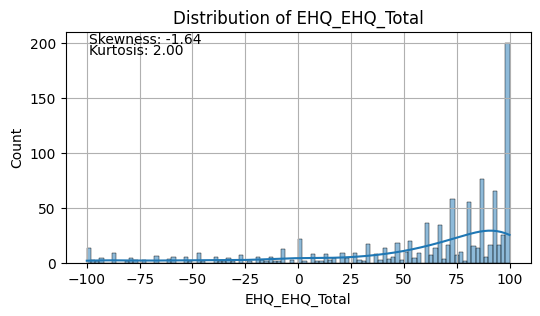

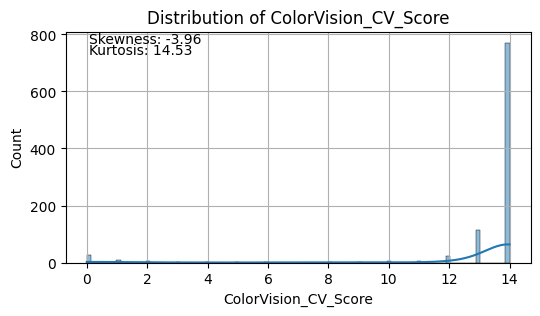

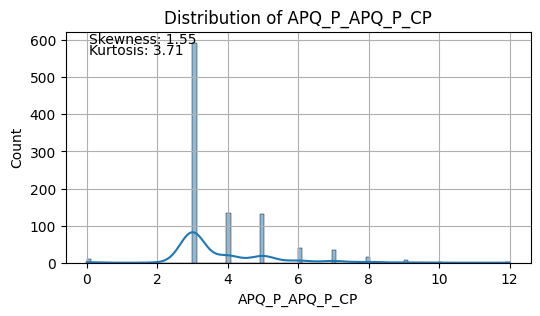

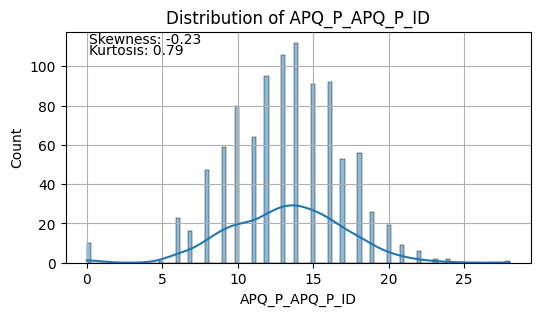

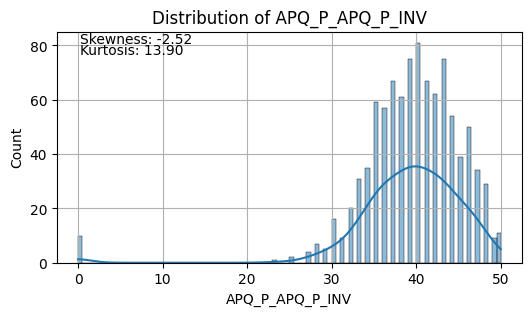

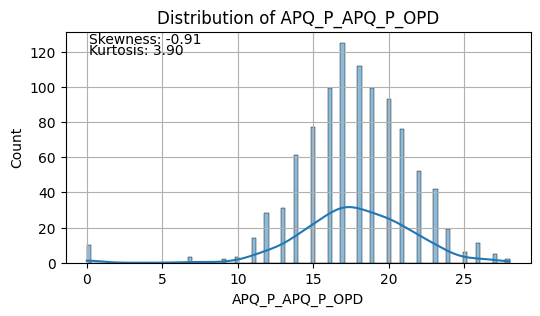

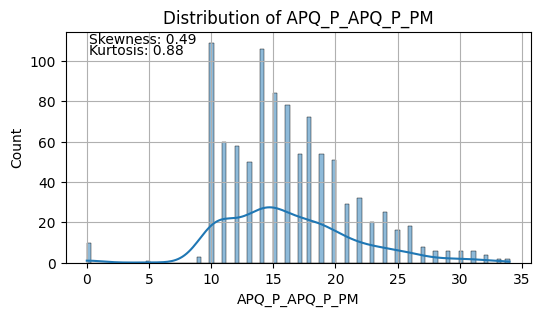

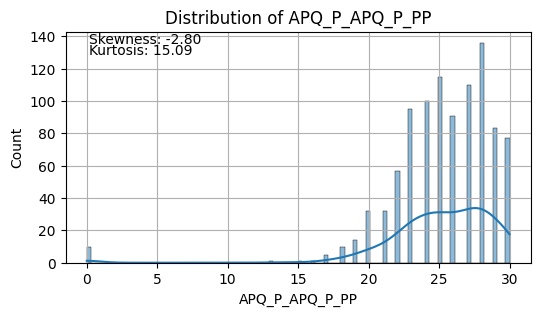

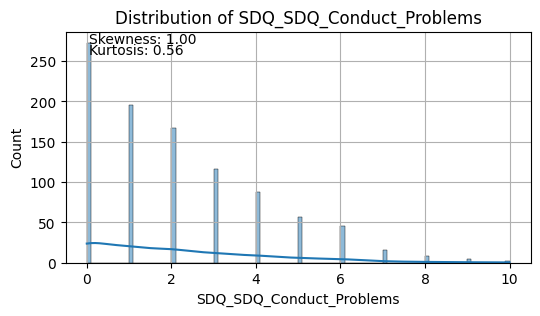

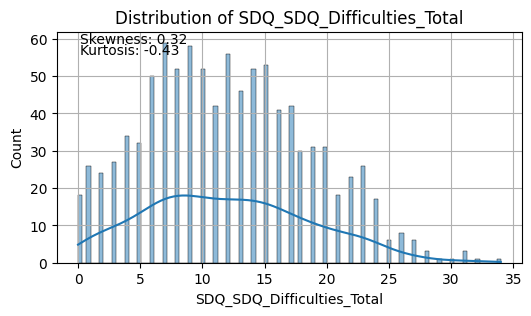

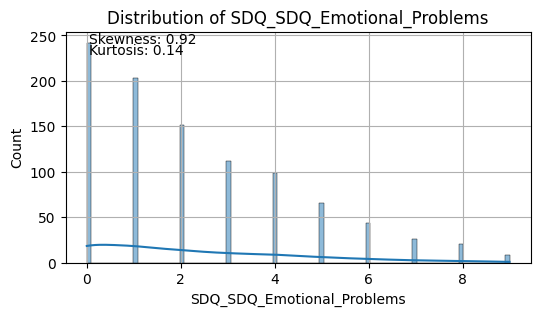

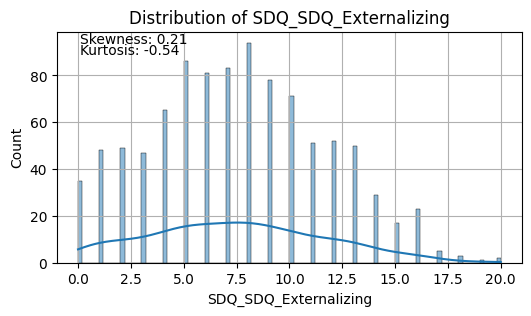

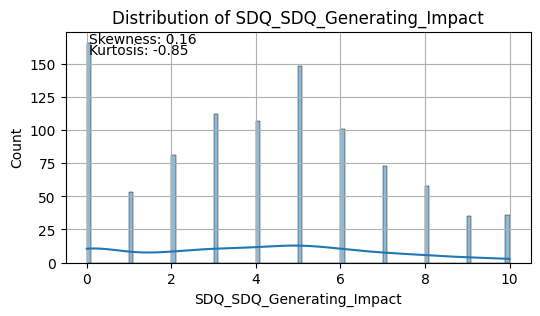

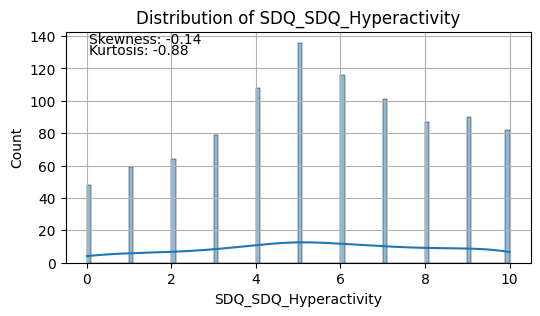

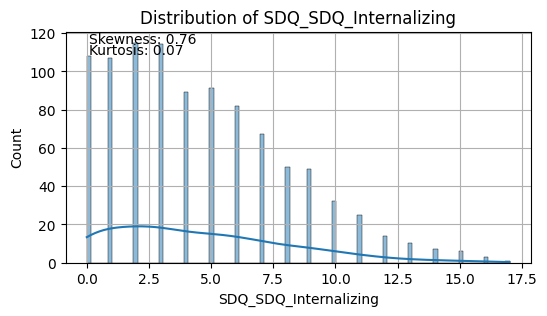

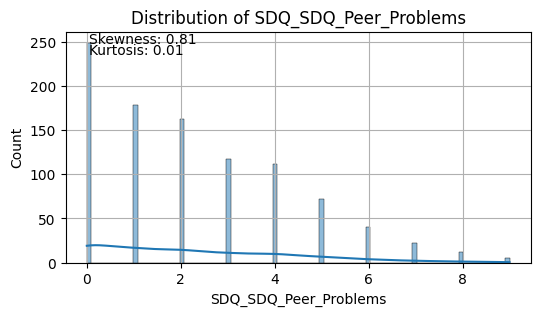

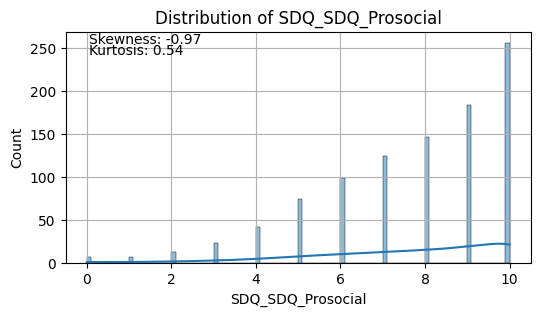

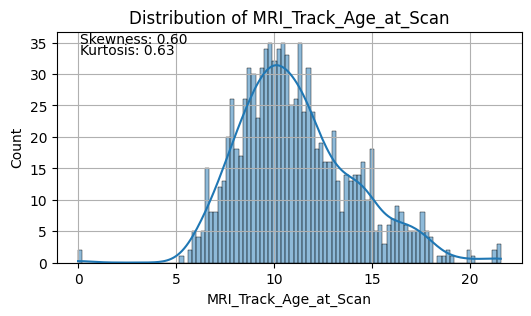

In [18]:
for col in data:
    plt.figure(figsize=(6, 3)) # This holds the figure size of each plot.
    sns.histplot(data[col], kde=True, bins = 100, fill = True) # Holds parameters of bins, if the plot will be filled and the line of tendency kde.
    plt.title(f"Distribution of {col}") # A title is assigned to the plot.
    plt.text(0.05, 0.95, f"Skewness: {data[col].skew():.2f}", transform=plt.gca().transAxes) # The calculation of skewness is made and showed on the plot.
    plt.text(0.05, 0.90, f"Kurtosis: {data[col].kurtosis():.2f}", transform=plt.gca().transAxes) # The calculation of kurtosis is made and showed on the plot.
    plt.grid(True) # Grid is displayed.
    plt.show() # The plot is made.

According to the distribution plots of each column, it is important to highlight that most of them have a distribution leaning towards to either side, and not following an expected normal distribution, obtaining a maximum kurtosis of 15.09 and a skewness of -2.52, which, in general terms indicates that the data does not follow a normal distribution which might significantly impact the performance of the models given that SVM and Logistic Regression are highly sensitive to non normalized data, leading to low precision and bias during classification. For this case, the Quantile transformer will be implemented for correcting the kurtosis asuring the value of this is nearly 3 and regarding the skew, a value close to 0.

The next section of code will display the correlation matrix for the features included in the train set of metadata_a and labels.

In [19]:
dataA_labels = pd.concat([data, labels], axis = 1) # This line of code merges the train set of Metadata_A and the labels with the columns.

The following code plots the correlation matrix of Metadata_A and the labels.

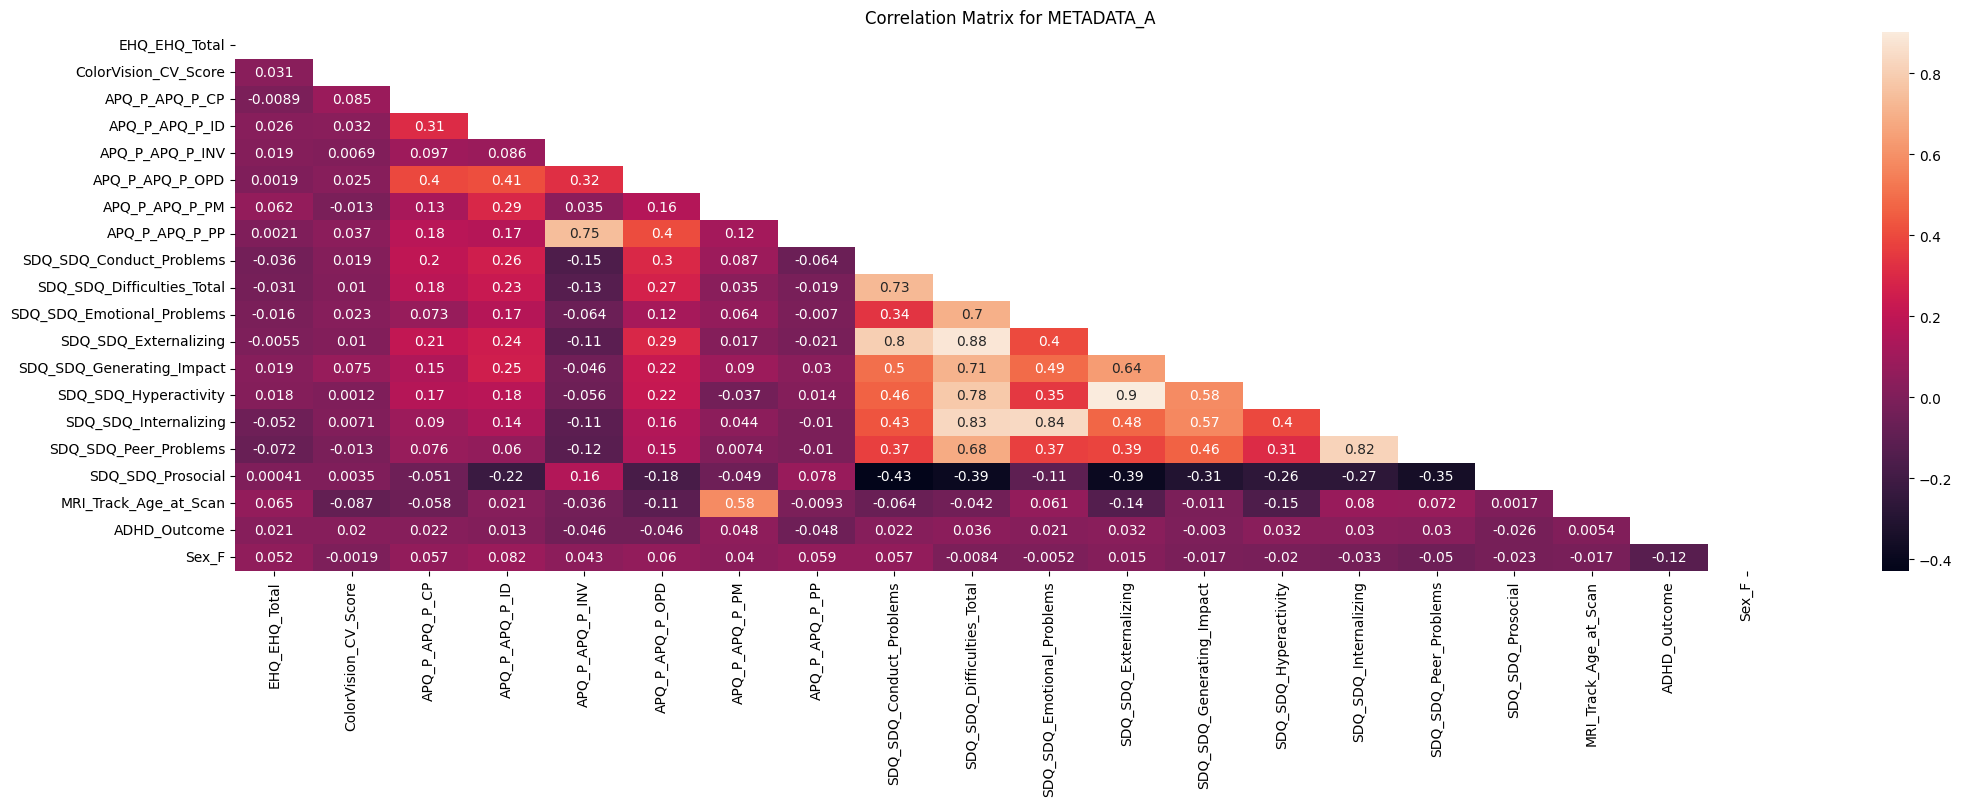

In [20]:
corr_map(dataA_labels.corr(), title = 'Correlation Matrix for METADATA_A') # Here, the input is data merged along with the plot title.

The heatmap represents that the columns SDQ_Difficulties and SDQ_Externalizing are highly correlated with a value of 0.88. This might lead to conclude that the use of positive discipline, constant monitoring and corporal punishment is highly related to the fact that children has experienced problems such as social impairment, distress and burden to others. Also, it is important to mention that Conduct Problems and Externalizing are highly correlated, indicating that as said before, it is more likely that the child will have problems when there are parenting problems leading this to be reflected on the conduct. Also, the parenting has a high correlation with the child hyperactivity, where a more constant parent presence in child's life might influence in child's energy on a daily basis.

The following line prints the countplot in a descending way showing how the columns are correlated to each label following the heatmap previously obtained. Also, a dataframe with the exact values are showed in order to provide what values were obtained and what columns might be candidate to be removed. Finally, shows what columns were deleted either by high correlation between the features or low correlation with labels.

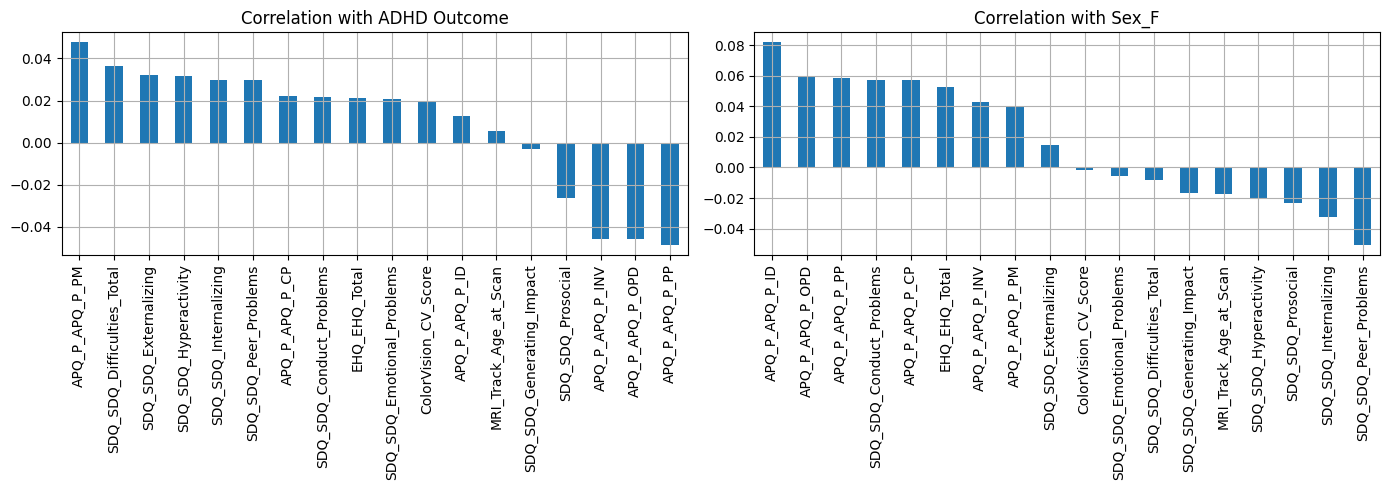

,ADHD_Outcome,Sex_F
EHQ_EHQ_Total,0.021201,0.052355
ColorVision_CV_Score,0.019594,-0.001855
APQ_P_APQ_P_CP,0.022343,0.057398
APQ_P_APQ_P_ID,0.012732,0.081732
APQ_P_APQ_P_INV,-0.045539,0.042669
APQ_P_APQ_P_OPD,-0.045992,0.059903
APQ_P_APQ_P_PM,0.047597,0.039939
APQ_P_APQ_P_PP,-0.048406,0.058758
SDQ_SDQ_Conduct_Problems,0.021650,0.057499
SDQ_SDQ_Difficulties_Total,0.036238,-0.008422


The column SDQ_SDQ_Externalizing was deleted from the data (High correlation with another column).
The column SDQ_SDQ_Hyperactivity was deleted from the data (High correlation with another column).
The column SDQ_SDQ_Internalizing was deleted from the data (High correlation with another column).
The column SDQ_SDQ_Peer_Problems was deleted from the data (High correlation with another column).


In [21]:
cols = label_countplot(dataA_labels, data) # The funcion label_countplot is called, whose inputs are the data merged and the data itself.

Considering the results obtained from the sorted countplot, all the features from this dataset have a very low correlation with the label, indicating that each feature associated with the difficulties and parenting might be not related to the presence of ADHD and also, even though sex has still a low correlation with the results obtained from the questionnaires, the overall correlation is higher than the presence of ADHD in the participants. This plot gives a zoom in on the correlation values from the heatmap regarding the features and labels and helps to determine what is the relationship in general with the label and see which one has more impact with the questionnaires.

On the other hand, it is important to showcase that none of the correlation obtained is not candidate to be removed (not below 0.005 if positive and not above -0.005 if negative). Nevertheless, the analysis from the correlation map within features, as seen, 4 columns were removed given that its correlation value was above 0.8.

In [22]:
data_test.drop(cols, axis = 1, inplace = True) # Here, the columns removed previously are now removed in the test data of the Metadata_A.

## **Metadata_B: Analysis in depth**

Now, let's see what's the percentage of NaNs in this dataset and how many are.

In [23]:
missing_data = perc_nans(dataB) # Here is called the function and returns a dataframe whose index holds the column with the NaNs with the number and percentage.

These are the columns with the percentage of missing values:

                                   Total  Percentage
PreInt_Demos_Fam_Child_Ethnicity      6        0.01


Given that the number of NaNs is 0.01% of the data (6 rows), the best approach in order to solve this considering that this is a column with categorical values, is replacing by the mode of the column, the most repeated value.

In [24]:
mod_dataB = dataB[missing_data.index[0]].mode()[0] # Given that mode() return a series of modes, in this case it is only important to consider the first value,
# the most repeated number of the column.
dataB[missing_data.index[0]].fillna(mod_dataB, inplace=True) # This line replaces the NaNs with the mode acquired into the dataset.
dataB_test = X_test[dataB.columns] # Here, a copy of the test set including only the columns of the data B set is created.
dataB_test[missing_data.index[0]].fillna(mod_dataB, inplace=True) # Now, the NaNs are modified with the mode in the test set.

The following section prints out the countplots of each column of the dataset B, where invalid values different from the expected from the given dictionary can be determined and analyzed.

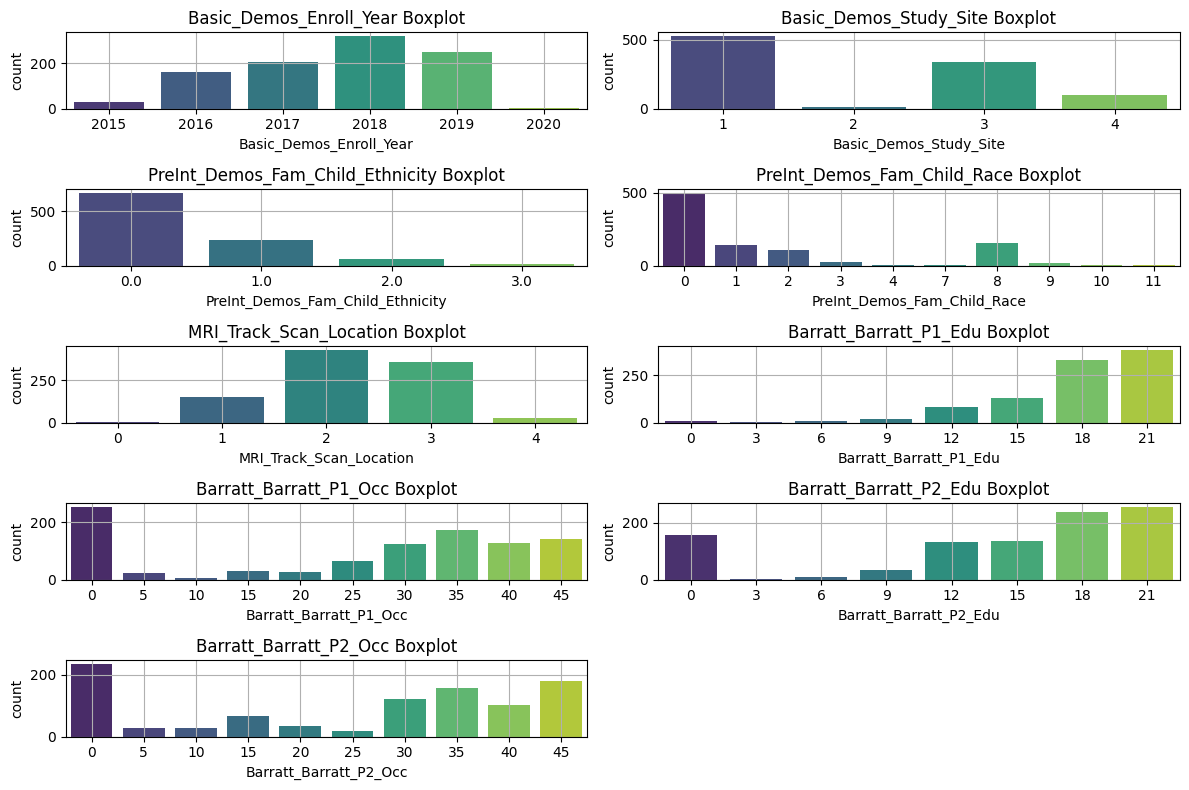

In [25]:
countplots(dataB.columns, dataB, True, title = 'Boxplot')

According to the Data dictionary, as seen in the previous plots, the columns "*MRI_Track_Scan_Location*", "*Barratt_Barratt_P1_Edu*" and "*Barratt_Barratt_P2_Edu*" have non valid values, therefore, in this case, is necessary to perform a data correction.

Now, considering the column "*MRI_Track_Scan_Location*" and the former plots, all those rows that have a value below 1, will be modified and replaced by 1 since they are most likely to be considered as the lowest scan location number (Staten Island), which according to the dictionary, there are only values expected from 1 to 4.

In [26]:
# The following lines replace all those values in the column "MRI_Track_Scan_Location" that are equal or below 1 for 1 in the train and test data.
dataB['MRI_Track_Scan_Location'] = dataB['MRI_Track_Scan_Location'].apply(lambda x: x if x > 1 else 1)
dataB_test['MRI_Track_Scan_Location'] = dataB_test['MRI_Track_Scan_Location'].apply(lambda x: x if x > 1 else 1)

Since the dictionary states that *Barratt_Barratt_P1_Edu* must take integer values in steps of 3 from 3 to 21, and initially there were values of 0, these will be replaced with 3, since it's considered that these participants belong to the lowest level of education. This problem probably might be related to a typo problem from the data collector.

In [27]:
# The following lines replace all those values in the column "Barratt_Barratt_P1_Edu" that are equal or below 3 for 3 in the train and test data.
dataB['Barratt_Barratt_P1_Edu'] = dataB['Barratt_Barratt_P1_Edu'].apply(lambda x: x if x > 3 else 3)
dataB_test['Barratt_Barratt_P1_Edu'] = dataB_test['Barratt_Barratt_P1_Edu'].apply(lambda x: x if x > 3 else 3)

Regarding *Barratt_Barratt_P2_Edu*, the same problem happened as the former column. In this case, the values below 3 will be replaced with 3 since it is most likely that the value is considered that the parent 2 has the lowest level of education.

In [28]:
dataB['Barratt_Barratt_P2_Edu'] = dataB['Barratt_Barratt_P2_Edu'].apply(lambda x: x if x > 3 else 3)
dataB_test['Barratt_Barratt_P2_Edu'] = dataB_test['Barratt_Barratt_P2_Edu'].apply(lambda x: x if x > 3 else 3)

Now, it's time to check how correlated is this dataset with the labels.

In [29]:
dataB_labels = pd.concat([dataB, labels], axis = 1) # This line of code merges the train set of Metadata_B and the labels with the columns.

The following line obtains the correlation matrix using the method mutual information for classification for the training set of Metadata_B and labels concatenated.

In [30]:
dataB_mi = dataB_labels.corr(method=mi_cl) # This line performs the calculation of MI and the matrix is returned and saved in dataB_mi.

Code taken from: https://www.geeksforgeeks.org/calculating-pairwise-mutual-information-in-pandas/

Now, the following plots the correlation matrix.

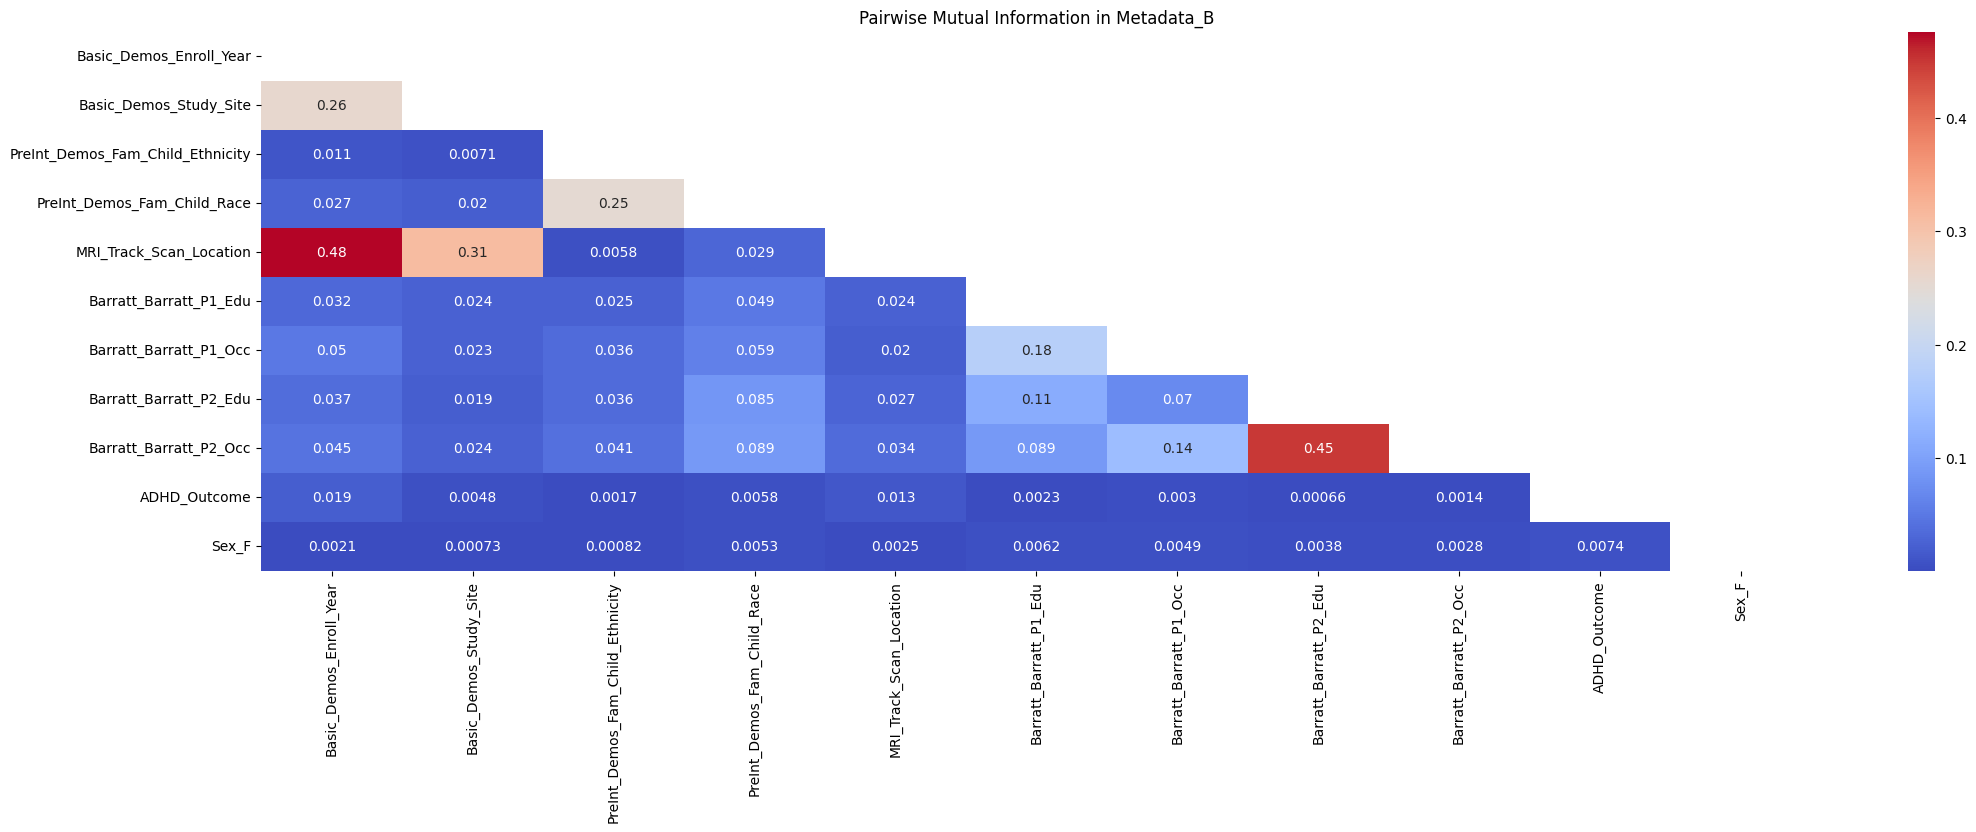

In [31]:
corr_map(dataB_mi, title = 'Pairwise Mutual Information in Metadata_B', palette = 'coolwarm') # Here the parameters are the MI matrix, the palette of colours which is
# coolwarm and the title.

The correlation matrix shows that in general terms, the features are not really correlated to each other, mainly because most of the correlation values are even below 0.2. However, it is possible to conclude that the education and the occupation only of the parent 2 have a considerable correlation, indicating that the more the higher was the level of education, the higher or more impactful was his/her job, but in the case of the parent 1, this relation is not remarkable.

Alternatively, the scan location and the year of enrollment are moderately correlated, which might indicate that the place of scanning has been changing or has been moved as the years go by. Finally, the scan location has also a correlation with the study site, showcasing that the scanning process was mostly made in a place near the phenotypic study site for ease of the laboratory and cost purposes.

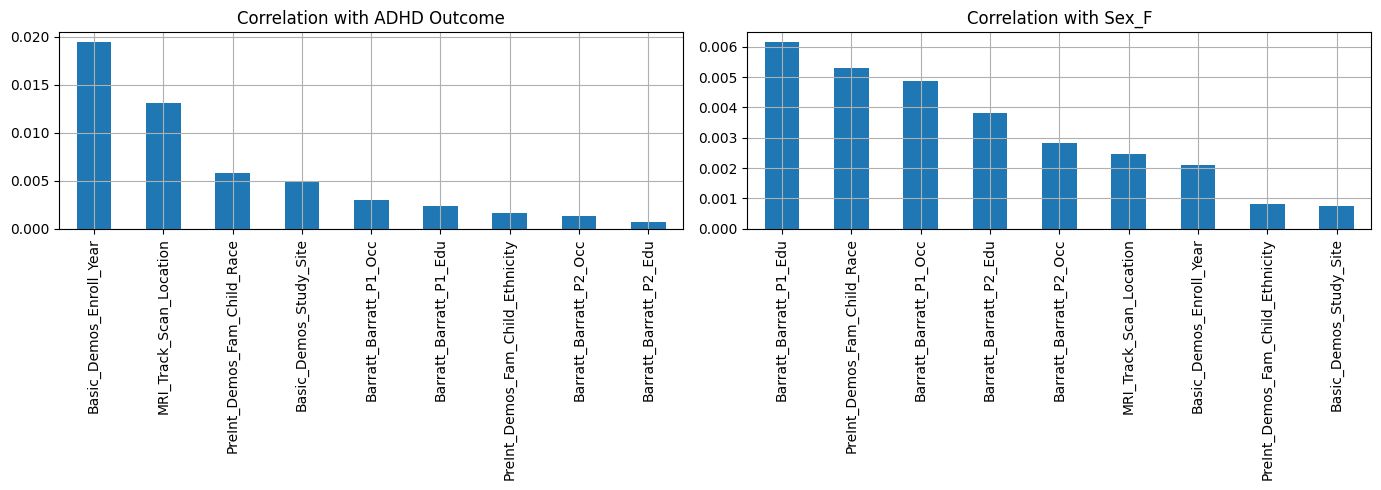

,ADHD_Outcome,Sex_F
Basic_Demos_Enroll_Year,0.019463,0.002113
Basic_Demos_Study_Site,0.004828,0.000735
PreInt_Demos_Fam_Child_Ethnicity,0.001654,0.000822
PreInt_Demos_Fam_Child_Race,0.005809,0.005318
MRI_Track_Scan_Location,0.013079,0.002477
Barratt_Barratt_P1_Edu,0.002324,0.006170
Barratt_Barratt_P1_Occ,0.002957,0.004876
Barratt_Barratt_P2_Edu,0.000661,0.003831
Barratt_Barratt_P2_Occ,0.001358,0.002822


The column Basic_Demos_Study_Site was deleted from the data (Low importance and Low Correlation with labels).
The column PreInt_Demos_Fam_Child_Ethnicity was deleted from the data (Low importance and Low Correlation with labels).
The column Barratt_Barratt_P1_Occ was deleted from the data (Low importance and Low Correlation with labels).
The column Barratt_Barratt_P2_Edu was deleted from the data (Low importance and Low Correlation with labels).
The column Barratt_Barratt_P2_Occ was deleted from the data (Low importance and Low Correlation with labels).


In [32]:
cols = label_countplot(dataB_labels, dataB, method = mi_cl) # The cols removed are obtained. These will be used to also be deleted in the
# test set.
dataB_test.drop(cols, axis = 1, inplace = True)

Analyzing the countplot provided, despite of having low correlations between the features and labels, it is possible to conclude that at a general level, the features in the dataset B are more likely to be correlated to the presence of ADHD in the participants than in the case of determining the sex.

Conversely, 5 columns from the dataset were removed given that its correlation in both cases was below 0.005 and does not contribute enough to the classification project.

Some of the columns removed indicate that parents education, occupation, ethnicity and phenotypic study does not influence or alter the presence of ADHD in children.

Now that most of the preprocessing has been made and also the removal of non significant columns was completed, the next step is to perform the encoding of the categorical data.

The following code will print the remaining columns and now, comparing with the dictionary, the type of encoders will be choosen depending on how many discrete values has each column.


In [33]:
dataB.columns # This line prints all the columns remaining in the dataframe.

Index(['Basic_Demos_Enroll_Year', 'PreInt_Demos_Fam_Child_Race',
       'MRI_Track_Scan_Location', 'Barratt_Barratt_P1_Edu'],
      dtype='object')

Given that there are 4 columns remaining, in the case of 'Fam_Child_Race', this column will hold a one hot encoder since there is no race that is above or has a higher value of importance and does not hold an order.

Regarding "Track_Scan_Location" and "Barratt_Barratt_P1_Edu" where each is associated to an ordinal feature. In the case of the P1, given that starts in 3 in steps of 3 up to 21, for simplicity and better data modelling is necessary to encode the feature in values from 0 to 6. Also, in Scan Location the numbers do not start in 0 so it is necessary to encode this column as well.

Before proceeding with the encoding, first, it's important to determine how many unique years are in the enroll year column. With this, the decision of encoding as one hot or as ordinal feature can be made.

In [34]:
dataB["Basic_Demos_Enroll_Year"].unique() # Here is extracted the values that appear in the column.

array([2019, 2016, 2018, 2015, 2017, 2020])

Since there are 6 different year values, creating another 6 columns is not suitable for this case, therefore, ordinal encoding is the proper alternative.

In [35]:
cols = ["Barratt_Barratt_P1_Edu", "Basic_Demos_Enroll_Year", "MRI_Track_Scan_Location"] # The columns to transform are saved in an array.
dataB["Barratt_Barratt_P1_Edu"].unique()

array([18, 15, 21,  3, 12,  6,  9])

The next section calls the ordinal encoder and converts the given columns into ordinal values.

In [36]:
enc = OrdinalEncoder() # The ordinal encoder is called and saved in the variable.
cols = ["Barratt_Barratt_P1_Edu", "Basic_Demos_Enroll_Year", "MRI_Track_Scan_Location"] # The columns to transform are saved in an array.
# Fit and transform on the training data.
enc.fit(dataB[cols])
# Apply the same transformation to the train and test set.
dataB[cols] = enc.transform(dataB[cols])
dataB_test[cols] = enc.transform(dataB_test[cols])

In [37]:
print(dataB.shape, dataB_test.shape)

(970, 4) (243, 4)


In [38]:
display(dataB.head())
display(dataB_test.head())

,Basic_Demos_Enroll_Year,PreInt_Demos_Fam_Child_Race,MRI_Track_Scan_Location,Barratt_Barratt_P1_Edu
971,4.0,8,2.0,5.0
352,1.0,2,1.0,4.0
676,3.0,1,2.0,6.0
671,3.0,1,2.0,0.0
982,3.0,0,1.0,3.0


,Basic_Demos_Enroll_Year,PreInt_Demos_Fam_Child_Race,MRI_Track_Scan_Location,Barratt_Barratt_P1_Edu
382,3.0,0,2.0,5.0
787,3.0,0,1.0,6.0
43,2.0,0,1.0,6.0
155,3.0,0,2.0,6.0
493,4.0,2,2.0,5.0


The following code converts the column "PreInt_Demos_Fam_Child_Race" into a one hot encoder since the race can not be an ordinal variable.



In [39]:
dataB = pd.get_dummies(dataB, columns=["PreInt_Demos_Fam_Child_Race"]) # One hot conversion of the training dataset.
dataB_test = pd.get_dummies(dataB_test, columns=["PreInt_Demos_Fam_Child_Race"]) # One hot conversion of the test dataset.

In [40]:
print(dataB.shape, dataB_test.shape)

(970, 13) (243, 13)


NOTE: No depth analysis was made to data_max because when calculating the correlation matrix, this took an indefinite amount of time leading the code to stop running and forcing the environment to restart, making this analysis not viable given the computational limitations.

## **Final Data Preprocessing**

This section will perform the label conversion, from two labels into only one creating 4 different classes, data scaling using the robust scaler, skewness correction using the Quantile transformer and PCA (principal component analysis) for dataset dimension reduction.

The following code encodes the whole label dataset including training and test sets.

In [41]:
y_train = label_encoder(labels) # Encodes and returns the training labels.
y_test = label_encoder(labels_test) # Encodes and returns the test labels.

Considering now that labels have been labeled and transformed into 4 different classes, for analysis purposes it is important to determine how many patients are females and have ADHD, and with this, comprehend in depth how imbalanced are now the classes.

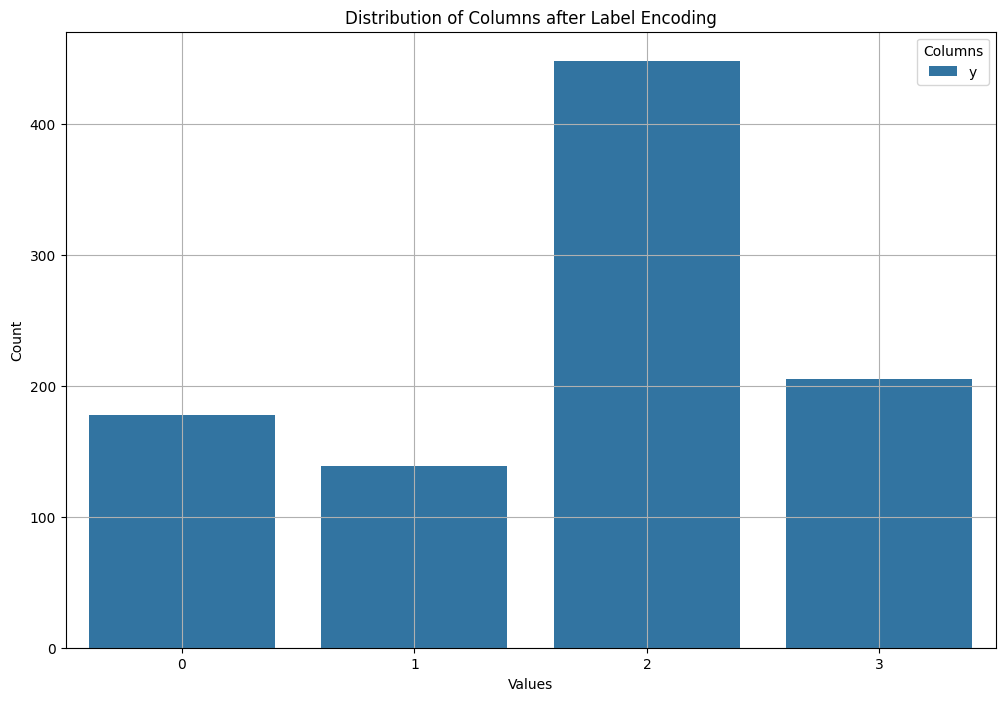

Category counts:
Not ADHD and Male: 178 (18.35%)
Not ADHD and Female: 139 (14.33%)
ADHD and Male: 448 (46.19%)
ADHD and Female: 205 (21.13%)


In [42]:
countplots(y_train.columns, y_train, False, title = 'Distribution of Columns after Label Encoding')
y_train['y'].value_counts().sort_index()

# Labels to print.
labels = {
    0: "Not ADHD and Male",
    1: "Not ADHD and Female",
    2: "ADHD and Male",
    3: "ADHD and Female"
}

# Sort ocurrencies of the labels acquired.
counts = y_train['y'].value_counts().sort_index()

# Print results using the tags.
print("Category counts:")
for class_id, count in counts.items():
    print(f"{labels[class_id]}: {count} ({count / counts.sum() * 100:.2f}%)")




Once done the label encoding, now it is important to perform the last feature selection process by using the method of RFE or "Recursive Feature Elimination" which will be applied on the training data, and then, when the least important features are obtained, these will be used to remove also the features on the test set. In addition, PCA was applied on the large data (19000+ columns).

In [43]:
data, datarfe_cols = rfe(data, y_train) # The data is reduced with RFE.
dataB, dataBrfe_cols = rfe(dataB, y_train) # The dataB is reduced with RFE.
data_test = data_test.drop(datarfe_cols, axis = 1) # The data_test is reduced with RFE.
dataB_test = dataB_test.drop(dataBrfe_cols, axis = 1) # The dataB_test is reduced with RFE.

pca = PCA(n_components=0.95)  # Set Variance held to 95 %.
data_max = pd.DataFrame(pca.fit_transform(data_max)) # Fit and transform the training data.
data_max_test = pd.DataFrame(pca.transform(data_max_test)) # Transform the test data.


The column EHQ_EHQ_Total was deleted from the data (Low importance).
The column APQ_P_APQ_P_ID was deleted from the data (Low importance).
The column Barratt_Barratt_P1_Edu was deleted from the data (Low importance).
The column PreInt_Demos_Fam_Child_Race_3 was deleted from the data (Low importance).


Once the data is ready to be transformed by the Skew corrector and scaler, the next step is to concatenate the numerical dataset, this includes data and data_max.

In [44]:
data_proc = pd.concat([data.reset_index(drop=True), data_max.reset_index(drop=True)], axis=1) # Since the indices of data were modified, is necessary to restart them all
# in order to avoid concatenation problems with data_max due to index mismatches.
 # the training sets data and data_max are concatenated in columns.
data_proc_test = pd.concat([data_test.reset_index(drop=True), data_max_test.reset_index(drop=True)], axis=1)
 # The test sets data and data_max are concatenated in columns.

Once concatenated, the next code will perform the skewness transformation using a Quantile transformer using an expected output of a normal distribution. This transformation will be applied to the data concatenated.

In [45]:
quantile_transformer = QuantileTransformer(output_distribution='normal') # The quantile transformer is saved with the given parameters. In this case its
# expected output is a normal distribution of data.
for col in (data_proc.columns): # This iterates over the columns of the numerical data concatenated and performs the fitting and transformation for each column.
  data_proc[col] = quantile_transformer.fit_transform(data_proc[[col]])
  data_proc_test[col] = quantile_transformer.transform(data_proc_test[[col]])

The following line converts the name of the columns into String in order to maintain a single data type and avoid problems during data scaling.

In [46]:
# Converts the data type of the columns name into string, this applies to training and test set.
data_proc.columns = data_proc.columns.astype(str)
data_proc_test.columns = data_proc_test.columns.astype(str)


The code below calls the scaler, saves the method into a variable and afterwards the scaling is performed towards the numerical dataset (training and test set).

In [47]:
scaler = RobustScaler() # Scaler is called.
data_proc = scaler.fit_transform(data_proc) # The scaler is fitted and transforms the training data.
data_proc_test = scaler.transform(data_proc_test) # The scaler modifies the test data.

Now, the last step is to concatenate the categorical data (data_B) into the training and test sets.

In [48]:
X_train = pd.concat([(pd.DataFrame(data_proc)).reset_index(drop=True), dataB.reset_index(drop=True)], axis=1) # Numerical and categorical training sets are concatenated.
X_test = pd.concat([(pd.DataFrame(data_proc_test)).reset_index(drop=True), dataB_test.reset_index(drop=True)], axis=1) # # Numerical and categorical test sets are concatenated.

In order to ensure that the column names have the same type of data, the columns will be modified by enumerating each one until the dataframe size is reached.

In [49]:
X_train.columns = np.arange(X_train.shape[1]) # The enumeration is made by .arange. This line modifies the column names by numbers on the train set.
X_test.columns = np.arange(X_test.shape[1]) # This line modifies the column names by numbers on the test set.

The lines below will export the data in .CSV format for its proper use in the second stage of the project.

In [50]:
X_train.to_csv('x_train.csv', index = False)
y_train.to_csv('y_train.csv', index = False)
X_test.to_csv('x_test.csv', index = False)
y_test.to_csv('y_test.csv', index = False)

### **END OF THE NOTEBOOK**